In [1]:
%matplotlib notebook

In [2]:
from decode_simple_network_replay import *
baks_alpha = 4.7725100028345535
baks_beta = 0.41969058927343522
baks_pad_dur = 3000.  # ms
baks_wrap_around = True
context.update(locals())

In [3]:
def get_run_data_from_file(run_data_file_path, run_data_key='0'):
    """

    :param run_data_file_path: str (path)
    :param run_data_key: str
    :return: tuple (array, dict, dict)
    """
    if not os.path.isfile(run_data_file_path):
        raise IOError('get_run_data_from_file: invalid data file path: %s' % run_data_file_path)

    run_full_spike_times_dict = defaultdict(dict)
    run_binned_firing_rates_dict = defaultdict(dict)
    run_tuning_peak_locs = dict()
    run_data_group_key = 'simple_network_exported_data'
    with h5py.File(run_data_file_path, 'r') as f:
        group = get_h5py_group(f, ['shared_context'])
        run_buffered_binned_t = group['buffered_binned_t'][:]
        run_binned_t = group['binned_t'][:]
        # run_full_binned_t = group['full_binned_t'][:]
        if 'tuning_peak_locs' in group and len(group['tuning_peak_locs']) > 0:
            subgroup = group['tuning_peak_locs']
            for pop_name in subgroup:
                run_tuning_peak_locs[pop_name] = dict()
                for target_gid, peak_loc in zip(subgroup[pop_name]['target_gids'], subgroup[pop_name]['peak_locs']):
                    run_tuning_peak_locs[pop_name][target_gid] = peak_loc
        group = get_h5py_group(f, [run_data_key, run_data_group_key])
        run_full_binned_t = group['full_binned_t'][:]
        subgroup = group['full_spike_times']
        for pop_name in subgroup:
            for gid_key in subgroup[pop_name]:
                run_full_spike_times_dict[pop_name][int(gid_key)] = subgroup[pop_name][gid_key][:]
    run_binned_dt = run_binned_t[1] - run_binned_t[0]
    run_binned_firing_rates_dict = \
        infer_firing_rates_baks(run_full_spike_times_dict, run_binned_t, alpha=context.baks_alpha,
                                beta=context.baks_beta, pad_dur=context.baks_pad_dur,
                                wrap_around=context.baks_wrap_around)
    run_inferred_binned_t = run_binned_t
    
    full_binned_spike_count_dict = get_binned_spike_count_dict(run_full_spike_times_dict, run_full_binned_t)
    full_pop_mean_rate_from_binned_spike_count_dict = \
            get_pop_mean_rate_from_binned_spike_count(full_binned_spike_count_dict, dt=run_binned_dt)
    
    # run_inferred_binned_t, run_binned_firing_rates_dict = \
    #    infer_firing_rates_from_spike_count(full_binned_spike_count_dict, input_t=run_full_binned_t,
    #                                        output_range=(run_buffered_binned_t[0], run_buffered_binned_t[-1]), 
    #                                        align_to_t=0., window_dur=100., step_dur=100.)
    
    sorted_gid_dict = defaultdict(dict)
    for pop_name in run_binned_firing_rates_dict:
        if pop_name in run_tuning_peak_locs:
            this_target_gids = np.array(list(run_tuning_peak_locs[pop_name].keys()))
            this_peak_locs = np.array(list(run_tuning_peak_locs[pop_name].values()))
            indexes = np.argsort(this_peak_locs)
            sorted_gid_dict[pop_name] = this_target_gids[indexes]
        else:
            this_target_gids = [int(gid_key) for gid_key in run_binned_firing_rates_dict[pop_name]]
            sorted_gid_dict[pop_name] = np.array(sorted(this_target_gids), dtype='int')

    run_firing_rates_matrix_dict = dict()
    for pop_name in run_binned_firing_rates_dict:
        run_firing_rates_matrix_dict[pop_name] = np.empty((len(run_binned_firing_rates_dict[pop_name]), len(run_inferred_binned_t)))
        for i, gid in enumerate(sorted_gid_dict[pop_name]):
            run_firing_rates_matrix_dict[pop_name][i, :] = run_binned_firing_rates_dict[pop_name][gid]
    
    return run_inferred_binned_t, run_firing_rates_matrix_dict, sorted_gid_dict, run_full_binned_t, full_pop_mean_rate_from_binned_spike_count_dict

In [4]:
# run_data_file_path = 'data/20200610_144659_simple_network_J_8_exported_output.hdf5'
# run_data_file_path = 'data/20200618_192138_simple_network_J_exported_output.hdf5'
run_data_file_path = 'data/20200619_163719_simple_network_J_exported_output.hdf5'
with h5py.File(run_data_file_path) as f:
    trial_keys = [key for key in f if key != 'shared_context']

In [5]:
start_time = time.time()
run_firing_rates_matrix_dict_list = []
full_pop_mean_rate_from_binned_spike_count_dict_list = []
run_full_binned_t_list = []
first = True
for trial_key in trial_keys:
    if first:
        run_binned_t, this_run_firing_rates_matrix_dict, sorted_gid_dict, run_full_binned_t, \
        this_full_pop_mean_rate_from_binned_spike_count_dict = \
            get_run_data_from_file(run_data_file_path, trial_key)
        first = False 
    else:
        _, this_run_firing_rates_matrix_dict, _, run_full_binned_t, \
            this_full_pop_mean_rate_from_binned_spike_count_dict = \
            get_run_data_from_file(run_data_file_path, trial_key)
    run_firing_rates_matrix_dict_list.append(this_run_firing_rates_matrix_dict)
    full_pop_mean_rate_from_binned_spike_count_dict_list.append(this_full_pop_mean_rate_from_binned_spike_count_dict)
    run_full_binned_t_list.append(run_full_binned_t)
print('Processing run data for %i trials took %.1f s' % (len(trial_keys), time.time() - start_time))

In [6]:
mean_trial_run_firing_rates_matrix_dict = dict()
trial_pop_sum_run_firing_rates_list_dict = defaultdict(list)
mean_trial_pop_sum_run_firing_rates_dict = dict()
sem_trial_pop_sum_run_firing_rates_dict = dict()
first = run_firing_rates_matrix_dict_list[0]
num_trials = len(run_firing_rates_matrix_dict_list)
for pop_name in first:
    trial_run_firing_rates_matrix_list = []
    for i in range(num_trials):
        this_trial_run_firing_rates_matrix = run_firing_rates_matrix_dict_list[i][pop_name]
        trial_run_firing_rates_matrix_list.append(this_trial_run_firing_rates_matrix)
        trial_pop_sum_run_firing_rates_list_dict[pop_name].append(np.sum(this_trial_run_firing_rates_matrix, axis=0))
    mean_trial_run_firing_rates_matrix_dict[pop_name] = np.mean(trial_run_firing_rates_matrix_list, axis=0)
    mean_trial_pop_sum_run_firing_rates_dict[pop_name] = np.mean(trial_pop_sum_run_firing_rates_list_dict[pop_name], axis=0)
    sem_trial_pop_sum_run_firing_rates_dict[pop_name] = \
        np.std(trial_pop_sum_run_firing_rates_list_dict[pop_name], axis=0) / np.sqrt(num_trials)

<IPython.core.display.Javascript object>


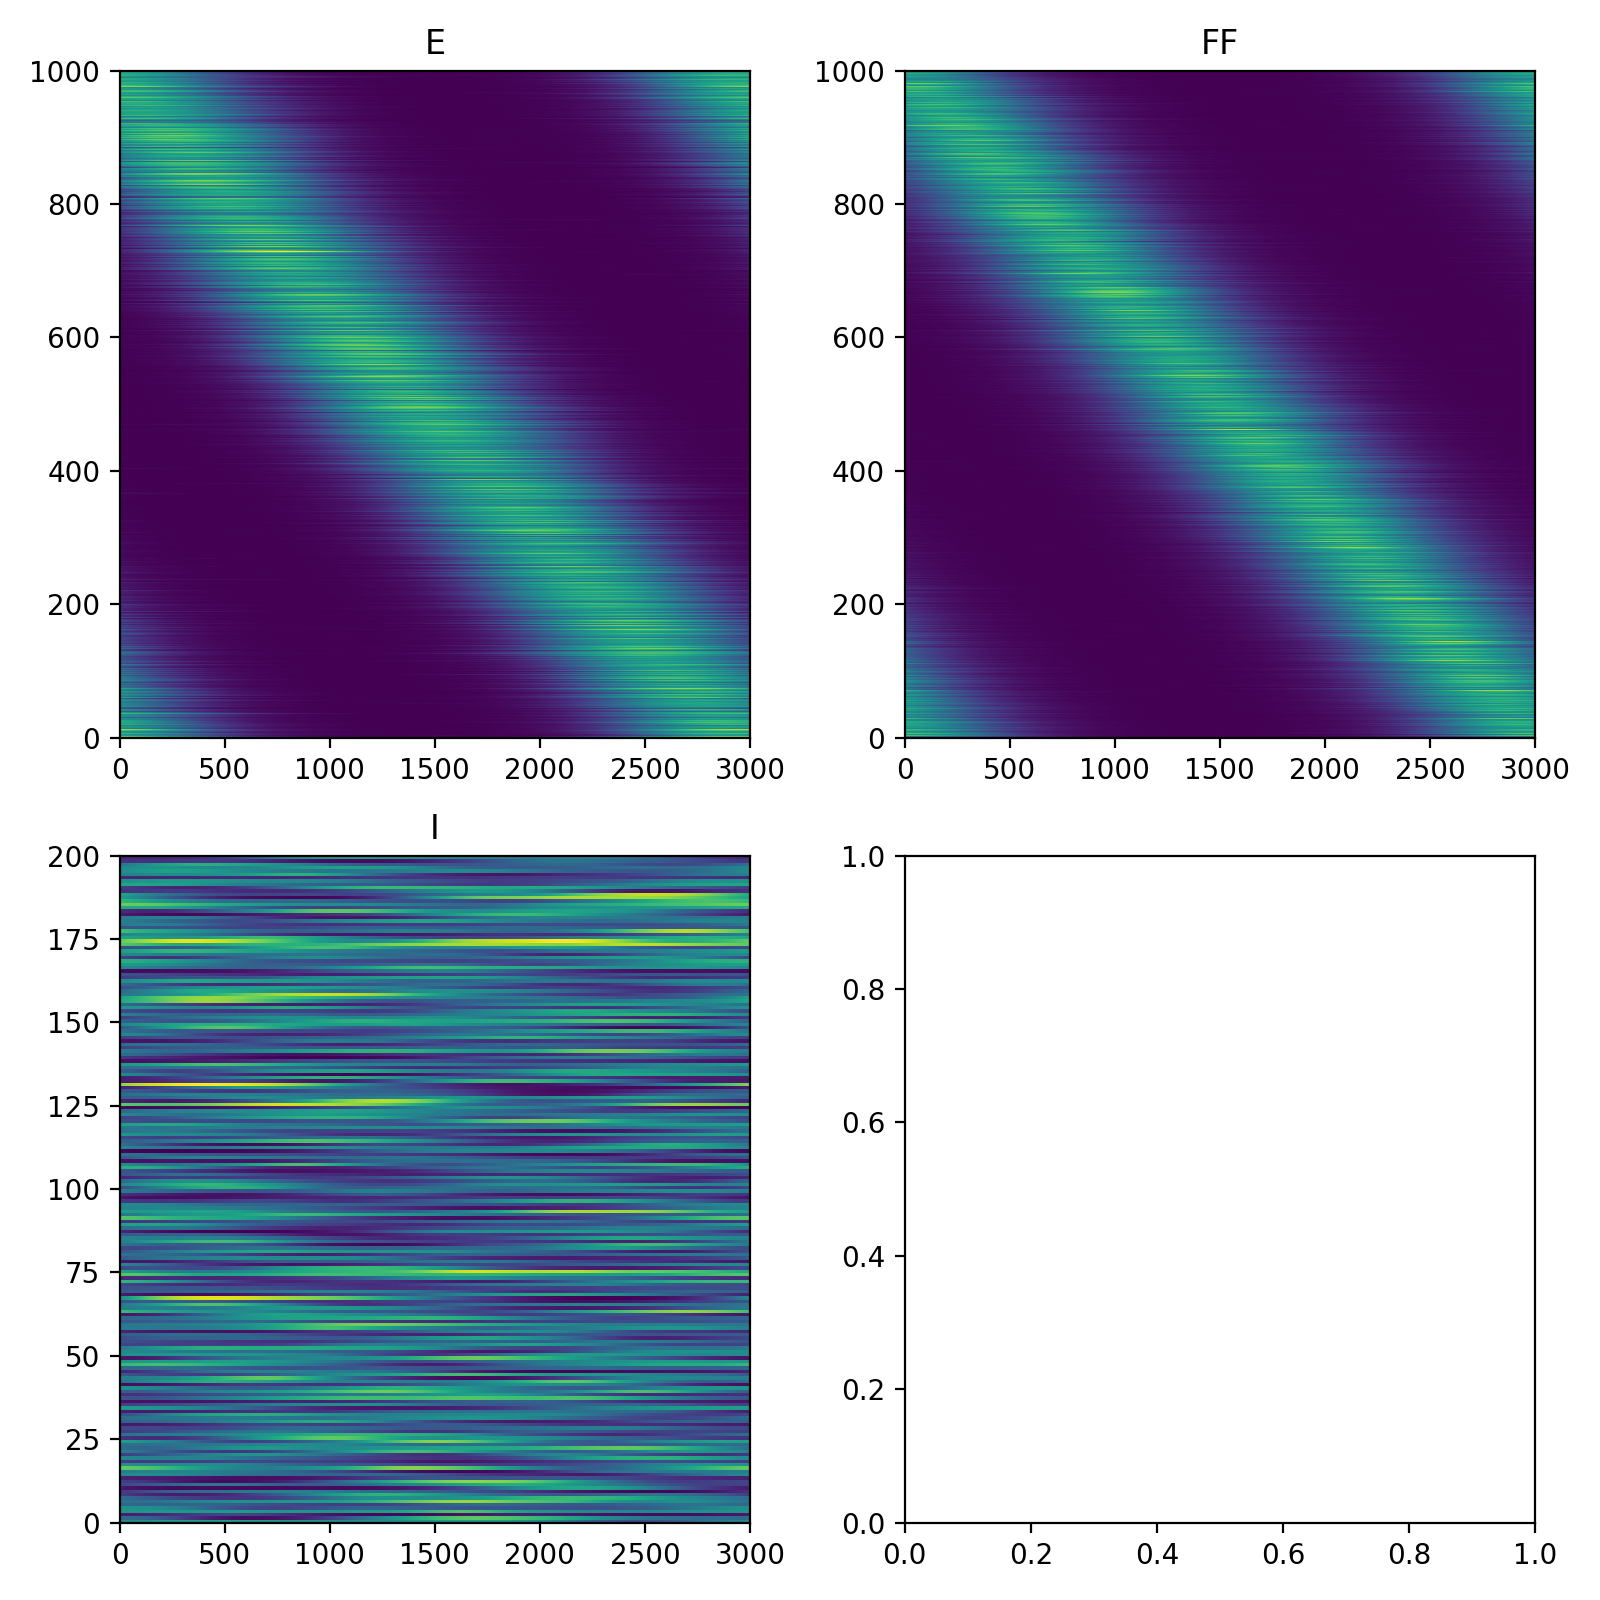

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(8., 8.))
for i, pop_name in enumerate(mean_trial_run_firing_rates_matrix_dict):
    axes.flat[i].imshow(mean_trial_run_firing_rates_matrix_dict[pop_name], 
                   extent=(run_binned_t[0], run_binned_t[-1], 0, len(sorted_gid_dict[pop_name])), aspect='auto')
    axes.flat[i].set_title(pop_name)
fig.tight_layout()

<IPython.core.display.Javascript object>


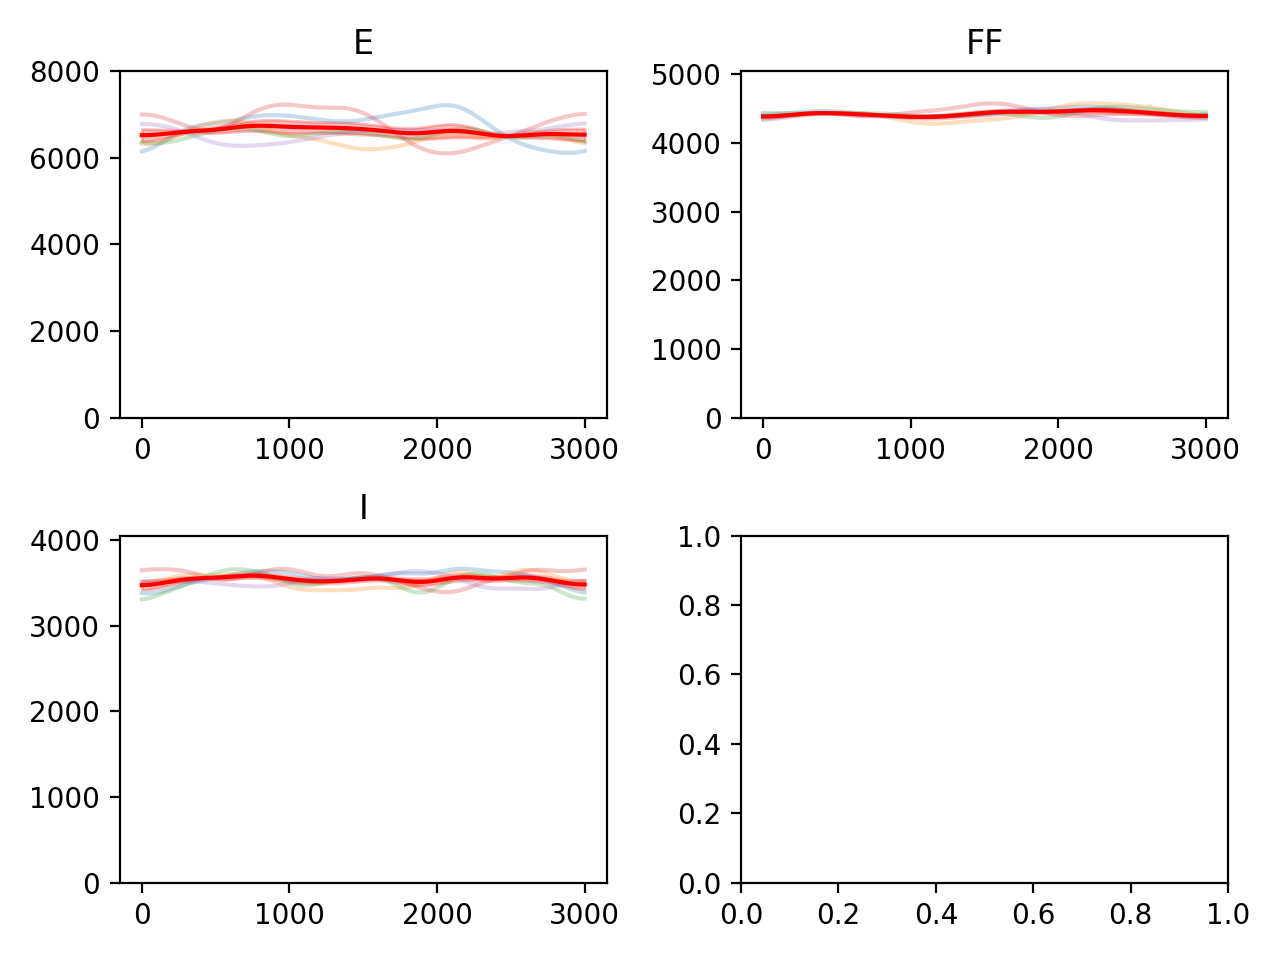

In [8]:
fig, axes = plt.subplots(2,2)
for i, pop_name in enumerate(trial_pop_sum_run_firing_rates_list_dict):
    for j in range(num_trials):
        axes.flat[i].plot(run_binned_t, trial_pop_sum_run_firing_rates_list_dict[pop_name][j], alpha=0.25)
    axes.flat[i].plot(run_binned_t, mean_trial_pop_sum_run_firing_rates_dict[pop_name], c='r')
    axes.flat[i].fill_between(run_binned_t, mean_trial_pop_sum_run_firing_rates_dict[pop_name] - 
                              sem_trial_pop_sum_run_firing_rates_dict[pop_name], 
                              mean_trial_pop_sum_run_firing_rates_dict[pop_name] + 
                              sem_trial_pop_sum_run_firing_rates_dict[pop_name], color='r', alpha=0.25)
    axes.flat[i].set_ylim((0., axes.flat[i].get_ylim()[1]*1.1))
    axes.flat[i].set_title(pop_name)
fig.tight_layout()

<IPython.core.display.Javascript object>


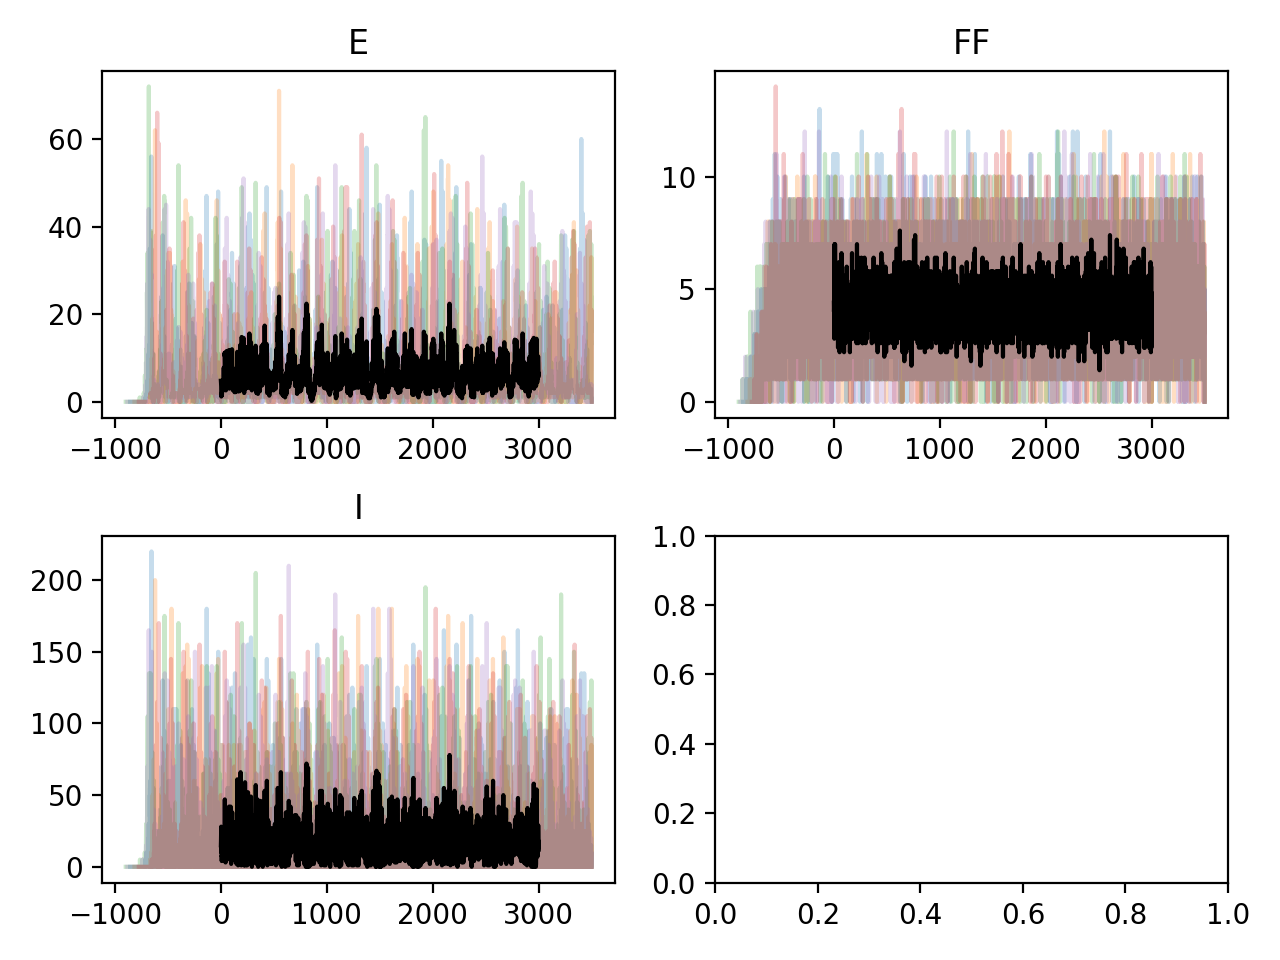

In [9]:
fig, axes = plt.subplots(2,2)
for i, pop_name in enumerate(full_pop_mean_rate_from_binned_spike_count_dict_list[0]):
    all_trials = []
    for j in range(num_trials):
        this_pop_mean_rate_from_binned_spike_count = np.interp(run_binned_t, run_full_binned_t_list[j],
                                                              full_pop_mean_rate_from_binned_spike_count_dict_list[j][pop_name])
        axes.flat[i].plot(run_full_binned_t_list[j], full_pop_mean_rate_from_binned_spike_count_dict_list[j][pop_name], 
                          alpha=0.25)
        all_trials.append(this_pop_mean_rate_from_binned_spike_count)
    axes.flat[i].plot(run_binned_t, np.mean(all_trials, axis=0), c='k')
    axes.flat[i].set_title(pop_name)
fig.tight_layout()

In [10]:
for run_t in run_full_binned_t_list:
    print(run_t[0])
    

-857.0
-816.0
-898.0
-775.0
-883.0


In [ ]:
pop_name = 'E'
run_full_spike_times_dict_list = []
run_buffered_binned_spike_count_list = []
run_buffered_firing_rates_list = []
run_full_binned_t_list = []
run_buffered_binned_t_list = []
run_tuning_peak_locs_list = []
run_data_group_key = 'simple_network_exported_data'
for run_data_key in trial_keys:
    with h5py.File(run_data_file_path, 'r') as f:
        group = get_h5py_group(f, ['shared_context'])
        run_buffered_binned_t = group['buffered_binned_t'][:]
        run_binned_dt = run_buffered_binned_t[1] - run_buffered_binned_t[0]
        run_buffered_binned_t_list.append(run_buffered_binned_t)
        if 'tuning_peak_locs' in group and len(group['tuning_peak_locs']) > 0:
            subgroup = group['tuning_peak_locs']
            run_tuning_peak_locs = dict()
            for target_gid, peak_loc in zip(subgroup[pop_name]['target_gids'], subgroup[pop_name]['peak_locs']):
                run_tuning_peak_locs[target_gid] = peak_loc
        run_tuning_peak_locs_list.append(run_tuning_peak_locs)
        group = get_h5py_group(f, [run_data_key, run_data_group_key])
        run_full_binned_t = group['full_binned_t'][:]
        run_full_binned_t_list.append(run_full_binned_t)
        run_full_spike_times_dict = dict()
        subgroup = group['full_spike_times']
        for gid_key in subgroup[pop_name]:
            run_full_spike_times_dict[int(gid_key)] = subgroup[pop_name][gid_key][:]
        run_full_spike_times_dict_list.append(run_full_spike_times_dict)
        run_buffered_binned_spike_count_dict = get_binned_spike_count_dict({pop_name: run_full_spike_times_dict}, run_buffered_binned_t)
        run_buffered_binned_spike_count_list.append(run_buffered_binned_spike_count_dict[pop_name])
        run_inferred_binned_t, run_buffered_firing_rates_dict = \
            infer_firing_rates_from_spike_count(run_buffered_binned_spike_count_dict, input_t=run_buffered_binned_t, 
                                                output_range=(run_buffered_binned_t[0], run_buffered_binned_t[-1]), 
                                                align_to_t=0., window_dur=20., step_dur=20.)
        run_buffered_firing_rates_list.append(run_buffered_firing_rates_dict[pop_name])

In [ ]:
trial = 0
gid = next(iter(run_buffered_binned_spike_count_list[trial]))
plt.figure()
plt.plot(run_buffered_binned_t_list[trial], run_buffered_binned_spike_count_list[trial][gid])

In [ ]:
plt.figure()
pop_sum_binned_spike_count_list = []
for trial in range(len(trial_keys)):
    pop_sum_binned_spike_count = np.sum(list(run_buffered_firing_rates_list[trial].values()), axis=0)
    pop_sum_binned_spike_count_list.append(pop_sum_binned_spike_count)
    plt.plot(run_inferred_binned_t, pop_sum_binned_spike_count, alpha=0.25)
plt.plot(run_inferred_binned_t, np.mean(pop_sum_binned_spike_count_list, axis=0), c='k')
plt.ylim((0., plt.ylim()[1]))

In [ ]:
plt.figure()
pop_sum_binned_spike_count_list = []
for trial in range(len(trial_keys)):
    pop_sum_binned_spike_count = np.sum(list(run_buffered_binned_spike_count_list[trial].values()), axis=0)
    pop_sum_binned_spike_count_list.append(pop_sum_binned_spike_count)
    plt.plot(run_buffered_binned_t_list[trial], pop_sum_binned_spike_count, alpha=0.25)
plt.plot(run_buffered_binned_t_list[trial], np.mean(pop_sum_binned_spike_count_list, axis=0), c='k')

In [ ]:
gid = 0
plt.figure()
pop_sum_binned_spike_count_list = []
for trial in range(len(trial_keys)):
    pop_sum_binned_spike_count = run_buffered_firing_rates_list[trial][gid]
    pop_sum_binned_spike_count_list.append(pop_sum_binned_spike_count)
    plt.plot(run_inferred_binned_t, pop_sum_binned_spike_count, alpha=0.25)
plt.plot(run_inferred_binned_t, np.mean(pop_sum_binned_spike_count_list, axis=0), c='k')

In [ ]:
for i in range(1, len(trial_keys)):
    print(np.all(run_buffered_binned_t_list[i] == run_buffered_binned_t_list[0]))

In [ ]:
[np.max(list(run_full_spike_times_dict_list[i].values())) for i in range(len(trial_keys))]

In [ ]:
max([np.max(spike_times) for spike_times in run_full_spike_times_dict_list[0].values()])

In [ ]:
input_t = run_buffered_binned_t_list[trial]
align_to_t=0.
window_dur=100.
step_dur=100.
smooth_dur=None

dt = input_t[1] - input_t[0]
half_window_bins = int(window_dur // dt // 2)
window_bins = int(2 * half_window_bins + 1)
window_dur = window_bins * dt
step_bins = step_dur // dt
if smooth_dur is not None:
    smooth_bins = int(smooth_dur // dt)
    if smooth_bins % 2 == 0:
        smooth_bins += 1

# if possible, include a starting at output_t[0]
binned_t_center_indexes = []
this_start_index = np.where(input_t >= align_to_t)[0]
if len(this_start_index) > 0:
    this_center_index = this_start_index[0] + half_window_bins
    while this_center_index >= half_window_bins:
        binned_t_center_indexes.append(this_center_index)
        this_center_index -= step_bins
    binned_t_center_indexes.reverse()
else:
    this_center_index = half_window_bins
    binned_t_center_indexes.append(this_center_index)
this_center_index = binned_t_center_indexes[-1] + step_bins
while this_center_index < len(input_t) - half_window_bins:
    binned_t_center_indexes.append(this_center_index)
    this_center_index += step_bins
binned_t_center_indexes = np.array(binned_t_center_indexes, dtype='int')
binned_t = input_t[binned_t_center_indexes]

In [ ]:
binned_t

In [ ]:
input_t[0]

In [ ]:
this_start_index

In [ ]:
input_t[binned_t_center_indexes[0]-half_window_bins]

In [ ]:
input_t[550]

In [ ]:
plt.xlim()